# Train The Ripeness Detection Model

This training script is responsible for fine-tuning an EfficientNet-v2S model on our ripeness dataset. This notebook is a modifed version of the notebook from this tutorial: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [1]:

import os
import keras
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import PIL
import time
import tensorflow as tf
from keras.layers.core import Dense, Flatten
from tensorflow.keras import layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torch.utils.data import random_split, Subset

from modules.datasets import RipenessDataset, EnsembleDataset, ClassificationWrapper, save_classification_dataset

## Dataset

First, we load the ripeness dataset and save it to the ripeness folder with an 70%/20%/10% train-val-test split.

In [2]:
ripeness_dataset_dir = os.path.join('..', 'dataset', 'ripeness')
train_dataset_dir = os.path.join(ripeness_dataset_dir, 'train')
val_dataset_dir = os.path.join(ripeness_dataset_dir, 'val')
test_dataset_dir = os.path.join(ripeness_dataset_dir, 'test')

os.makedirs(train_dataset_dir, exist_ok=True)
os.makedirs(val_dataset_dir, exist_ok=True)
os.makedirs(test_dataset_dir, exist_ok=True)

ensemble_ripeness_dir = os.path.join(ripeness_dataset_dir, 'ensemble_fine_tune')
ensemble_ripeness_val_dir = os.path.join(ripeness_dataset_dir, 'ensemble_fine_tune_val')

os.makedirs(ensemble_ripeness_dir, exist_ok=True)
os.makedirs(ensemble_ripeness_val_dir, exist_ok=True)

seed = 123
num_fine_tune_samples = 50
np.random.seed(seed)

In [3]:
ripeness_dataset = RipenessDataset()
dataset_len = len(ripeness_dataset)

# Split the dataset into train, validation and test sets, making sure that the size of each split adds up to the size of the original dataset.
train_dataset, val_dataset, test_dataset = random_split(ripeness_dataset, [round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len - dataset_len * .9)])

ensemble_dataset = EnsembleDataset()

# we use Subset on the ensemble dataset so that the images in the fine tune set are the same across the detection, ripeness, and defect training scripts
random_indices = np.random.permutation(len(ensemble_dataset))
fine_tune_indices = random_indices[:num_fine_tune_samples]
val_indices = random_indices[num_fine_tune_samples:]

fine_tune_dataset = ClassificationWrapper(Subset(ensemble_dataset, fine_tune_indices), label_type='ripeness')
ensemble_val_dataset = ClassificationWrapper(Subset(ensemble_dataset, val_indices), label_type='ripeness')

In [4]:
classnames = ['unripe', 'ripe']
save_classification_dataset(train_dataset, train_dataset_dir, classes=classnames)
save_classification_dataset(val_dataset, val_dataset_dir, classes=classnames)
save_classification_dataset(test_dataset, test_dataset_dir, classes=classnames)

save_classification_dataset(fine_tune_dataset, ensemble_ripeness_dir, classes=classnames)
save_classification_dataset(ensemble_val_dataset, ensemble_ripeness_val_dir, classes=classnames)

Saving dataset to ..\dataset\ripeness\test: 100%|██████████| 136/136 [00:03<00:00, 37.13it/s]
Saving dataset to ..\dataset\ripeness\ensemble_fine_tune: 100%|██████████| 185/185 [00:00<00:00, 459.67it/s]
Saving dataset to ..\dataset\ripeness\ensemble_fine_tune_val: 100%|██████████| 417/417 [00:00<00:00, 460.76it/s]


In [5]:
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset_dir,
    class_names=classnames,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 952 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset_dir,
    class_names=classnames,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 272 files belonging to 2 classes.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_dir,
    seed=seed,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 136 files belonging to 2 classes.


We also have to create datasets for the fine-tuning of the ensemble model.

In [8]:
ensemble_fine_tune_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ensemble_ripeness_dir,
    seed=seed,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 185 files belonging to 2 classes.


In [9]:
ensemble_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    ensemble_ripeness_val_dir,
    seed=seed,
    class_names=classnames,
    image_size=(img_height, img_width),
    batch_size=batch_size,)

Found 417 files belonging to 2 classes.


Let's take a look at some of the images in the dataset.

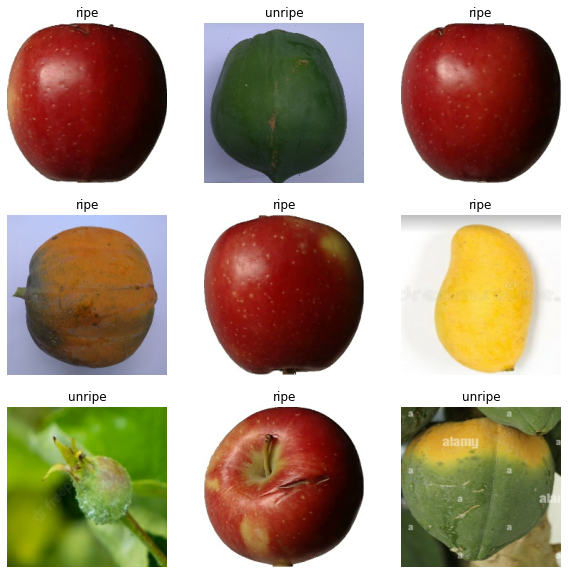

In [10]:

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames[labels[i]])
        plt.axis("off")

## Model

We use a pre-trained EfficientNet-v2 model and fine-tune it on our ripeness dataset.

In [11]:
# Importing EfficientNet V2
effcientnet_v2_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2,
    classifier_activation="softmax")


for layer in effcientnet_v2_model.layers:
        layer.trainable=False

In [12]:
# We run into issues with overfitting in our model, so we experimented with data augmentation
augmentaton = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [13]:
# Importing pre trained model

ripeness_model = Sequential([
    effcientnet_v2_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

In [14]:
# Model Summary

ripeness_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 20,988,258
Trainable params: 656,898
Non-trainable params: 20,331,360
_________________________________________________________________


## Training



In [15]:
# Training

ripeness_model.compile(optimizer=Adam(learning_rate=0.002),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [16]:
epochs=8

history = ripeness_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
30/30 [==============================] - 20s 294ms/step - loss: 0.1373 - accuracy: 0.9296 - val_loss: 0.0575 - val_accuracy: 0.9816
Epoch 2/8
30/30 [==============================] - 6s 199ms/step - loss: 0.0313 - accuracy: 0.9884 - val_loss: 0.0217 - val_accuracy: 0.9926
Epoch 3/8
30/30 [==============================] - 6s 198ms/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.0591 - val_accuracy: 0.9779
Epoch 4/8
30/30 [==============================] - 6s 199ms/step - loss: 0.0154 - accuracy: 0.9926 - val_loss: 0.0207 - val_accuracy: 0.9890
Epoch 5/8
30/30 [==============================] - 6s 201ms/step - loss: 0.0057 - accuracy: 0.9989 - val_loss: 0.0134 - val_accuracy: 0.9926
Epoch 6/8
30/30 [==============================] - 6s 201ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9926
Epoch 7/8
30/30 [==============================] - 6s 201ms/step - loss: 8.4298e-04 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 8/

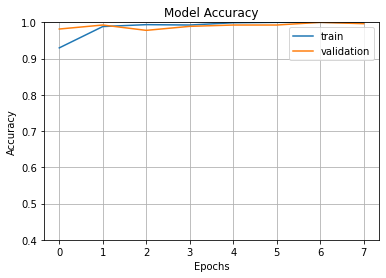

In [17]:
# Model Evaluation

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Now that the model is done training, we can save it. We save the model using a Keras SavedModel format. We need to copy the model to the weights folder before we can use it in DeepFruitVision.

In [18]:
# save the model
ripeness_model.save("ripeness_model")

INFO:tensorflow:Assets written to: ripeness_model\assets


INFO:tensorflow:Assets written to: ripeness_model\assets


## Evaluation

We can evaluate it on the test set, and we can create a confusion matrix to see how well the model performed.

In [19]:
ripeness_model.evaluate(test_ds)

5/5 [==============================] - 1s 184ms/step - loss: 0.0076 - accuracy: 0.9926


[0.0075634378008544445, 0.9926470518112183]

In [20]:
predictions = []
labels = []
for x, y in test_ds:
    predicted_categories = np.argmax(ripeness_model.predict(x), axis = 1)
    predictions.append(predicted_categories)
    labels.append(y)

predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

print(predictions.shape)
print(labels.shape)
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

1/1 [==============================] - 2s 2s/step
(136,)
(136,)


array([[66,  1],
       [ 0, 69]])

In [21]:
print(classification_report(labels, predictions, target_names=classnames))

              precision    recall  f1-score   support

      unripe       1.00      0.99      0.99        67
        ripe       0.99      1.00      0.99        69

    accuracy                           0.99       136
   macro avg       0.99      0.99      0.99       136
weighted avg       0.99      0.99      0.99       136



Now lets take a look at some of the model's predictions on the test set.

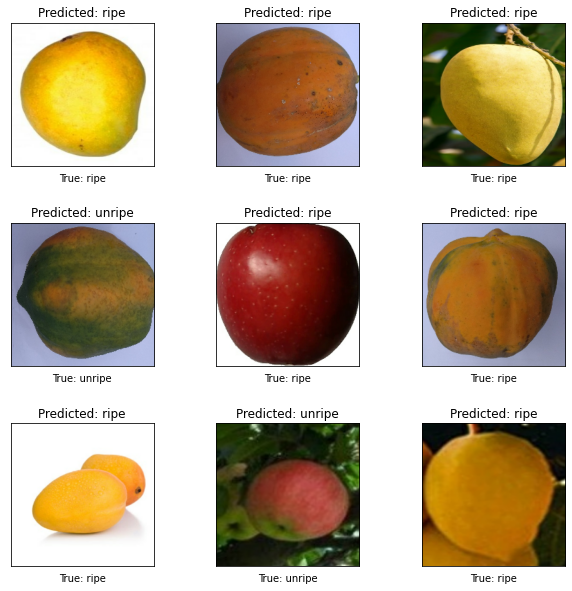

In [22]:
# Plotting some of the predictions using matplotlib

plt.figure(figsize=(10, 10))
# increase the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img, label = images[i], labels[i]
    pred_label = np.argmax(ripeness_model(np.expand_dims(img, axis=0)))
    plt.imshow(img.numpy().astype("uint8"))

    plt.title(f'Predicted: {classnames[pred_label]}')
    plt.xlabel(f'True: {classnames[int(label)]}')

    plt.xticks([])
    plt.yticks([])
plt.show()

Now that we are done with training and evaluation, we can clean up the ripeness dataset folder we created to save on disk space. This also lets us cleanly rerun the notebook without having to worry any dataset conflicts

## Ensemble Model

We've trained the model on the defect dataset, now we need to train the ensemble model on the defect dataset. We'll use the same model as before, but we'll train it on a small subset of our ensemble dataset. Before that, lets see how well the original model does on the ensemble validation dataset.

In [23]:
# load the ripeness model from the file
ripeness_model = tf.keras.models.load_model("ripeness_model")

In [24]:
# evaluate the model on the ensemble validation dataset
ripeness_model.evaluate(ensemble_val_ds)

14/14 [==============================] - 5s 154ms/step - loss: 2.2639 - accuracy: 0.6283


[2.2638864517211914, 0.6282973885536194]

Clearly, this model doesn't work well when we try to classify ripeness on the ensemble dataset. We'll need to fine-tune the model on the ensemble dataset to get better results.

In [25]:
ripeness_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# fine-tune the model on the ensemble dataset
epochs = 8
history = ripeness_model.fit(
    ensemble_fine_tune_ds,
    validation_data=ensemble_val_ds,
    epochs=epochs
)

Epoch 1/8
6/6 [==============================] - 15s 1s/step - loss: 0.8901 - accuracy: 0.8378 - val_loss: 0.7701 - val_accuracy: 0.8106
Epoch 2/8
6/6 [==============================] - 3s 517ms/step - loss: 0.4658 - accuracy: 0.8595 - val_loss: 0.5994 - val_accuracy: 0.8297
Epoch 3/8
6/6 [==============================] - 3s 539ms/step - loss: 0.1981 - accuracy: 0.9243 - val_loss: 0.5068 - val_accuracy: 0.8345
Epoch 4/8
6/6 [==============================] - 3s 533ms/step - loss: 0.1311 - accuracy: 0.9405 - val_loss: 0.4740 - val_accuracy: 0.8417
Epoch 5/8
6/6 [==============================] - 3s 536ms/step - loss: 0.0891 - accuracy: 0.9568 - val_loss: 0.4728 - val_accuracy: 0.8369
Epoch 6/8
6/6 [==============================] - 3s 532ms/step - loss: 0.0680 - accuracy: 0.9784 - val_loss: 0.4781 - val_accuracy: 0.8369
Epoch 7/8
6/6 [==============================] - 3s 534ms/step - loss: 0.0436 - accuracy: 0.9892 - val_loss: 0.4818 - val_accuracy: 0.8345
Epoch 8/8
6/6 [==============

As we can see, this is an improvement. Now we can show some more statistics.

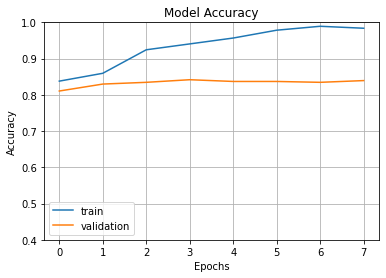

In [26]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [27]:
predictions = []
labels = []
for x, y in ensemble_val_ds:
    predicted_categories = np.argmax(ripeness_model.predict(x), axis = 1)
    predictions.append(predicted_categories)
    labels.append(y)


predictions = np.concatenate(predictions)
labels = np.concatenate(labels)

print(predictions.shape)
print(labels.shape)
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

1/1 [==============================] - 2s 2s/step
(417,)
(417,)


array([[191,  38],
       [ 29, 159]])

In [28]:
print(classification_report(labels, predictions, target_names=classnames))

              precision    recall  f1-score   support

      unripe       0.87      0.83      0.85       229
        ripe       0.81      0.85      0.83       188

    accuracy                           0.84       417
   macro avg       0.84      0.84      0.84       417
weighted avg       0.84      0.84      0.84       417



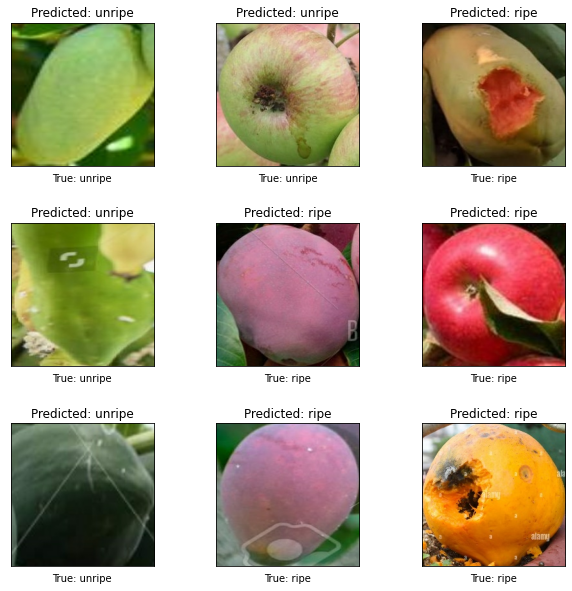

In [29]:
# Plotting some of the predictions using matplotlib

plt.figure(figsize=(10, 10))
# increase the space between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for images, labels in ensemble_val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img, label = images[i], labels[i]
    pred_label = np.argmax(ripeness_model(np.expand_dims(img, axis=0)))
    plt.imshow(img.numpy().astype("uint8"))

    plt.title(f'Predicted: {classnames[pred_label]}')
    plt.xlabel(f'True: {classnames[int(label)]}')

    plt.xticks([])
    plt.yticks([])
plt.show()

Lastly, let's check to make sure the model still does well on the original test set.

In [30]:
# evaluate the model on the test set
ripeness_model.evaluate(test_ds)

5/5 [==============================] - 1s 132ms/step - loss: 0.2700 - accuracy: 0.9044


[0.2699783146381378, 0.904411792755127]

## Cleaning Up

Now that we are done with training and evaluation, we can clean up the defect dataset folder we created to save on disk space. This also lets us cleanly rerun the notebook without having to worry any dataset conflicts. We also save the fine-tuned model at this point.

In [31]:
import shutil

# Cleaning up the defect dataset folder
shutil.rmtree(ripeness_dataset_dir)

In [32]:
# save the model
ripeness_model.save("ripeness_model_fine_tuned")

INFO:tensorflow:Assets written to: ripeness_model_fine_tuned\assets


INFO:tensorflow:Assets written to: ripeness_model_fine_tuned\assets
